# Gradient Boosting Classifier

In [76]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import pickle
import sys
import joblib
import os
import keras_tuner as kt

IMAGE_SIZE = [32, 32]

In [52]:
df = pd.read_json('../data/labelled_data/whole_data_1637521796.json', orient='records')

In [53]:
# Show amount of samples
print("amount of samples:", df.shape[0])
df.head(n=3)

amount of samples: 200


,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,Human
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,Human
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,Ambigous heat


In [54]:
# convert labels
binary_label_converter = { 
    'Human': 1,
    'Several humans': 1, 
    'Non-human heat': 0, 
    'Ambigous heat': 0,
    'No heat':  0,
}


df_binary = df.copy()

df_binary['label'] = df['label'].apply(lambda x: binary_label_converter[x])
df_binary.head(n=3)

,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,0


In [55]:
# Prepare the data
y = df_binary['label'].to_numpy()
X = np.array(df_binary['data'].to_list())
X = np.expand_dims(X, axis=3)
print(y.shape)
print(X.shape)

(200,)
(200, 32, 32, 1)


In [56]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(y_train[:1])

(180, 32, 32, 1)
(180,)
(15, 32, 32, 1)
(15,)
[0]


In [57]:
# Squeezenet Model

bnmomemtum=0.9

def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(64)(y)
y = tf.keras.layers.Dense(32)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(2, activation='softmax')(y)

model = tf.keras.Model(x, y)

In [58]:
model.compile(
optimizer='adam',
loss= 'sparse_categorical_crossentropy',
metrics=['accuracy'])
model.build(input_shape=(None, 32, 32, 1))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66  

In [59]:
# Plot the model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Epoch 1/30
12/12 [==============================] - 2s 53ms/step - loss: 0.9971 - accuracy: 0.5833 - val_loss: 1.0499 - val_accuracy: 0.6000
Epoch 2/30
12/12 [==============================] - 0s 24ms/step - loss: 0.7542 - accuracy: 0.5889 - val_loss: 0.7151 - val_accuracy: 0.6000
Epoch 3/30
12/12 [==============================] - 0s 31ms/step - loss: 0.8134 - accuracy: 0.6000 - val_loss: 0.7254 - val_accuracy: 0.4000
Epoch 4/30
12/12 [==============================] - 0s 24ms/step - loss: 0.7174 - accuracy: 0.5556 - val_loss: 0.7255 - val_accuracy: 0.6000
Epoch 5/30
12/12 [==============================] - 0s 18ms/step - loss: 0.7550 - accuracy: 0.5500 - val_loss: 0.6963 - val_accuracy: 0.3333
Epoch 6/30
12/12 [==============================] - 0s 16ms/step - loss: 0.6919 - accuracy: 0.5722 - val_loss: 0.6749 - val_accuracy: 0.6000
Epoch 7/30
12/12 [==============================] - 0s 17ms/step - loss: 0.7087 - accuracy: 0.5389 - val_loss: 0.7327 - val_accuracy: 0.6000
Epoch 8/30
12

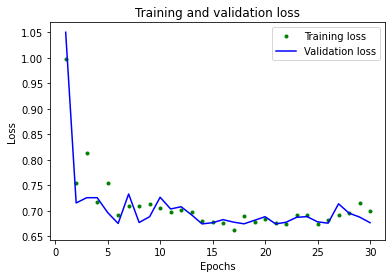

In [60]:
# Fit the model
EPOCHS = 30
BATCH_SIZE = 16
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))


train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [61]:
def get_feature_map_list(model):
    
    feature_map_list = []
        
    for i in range(len(model.layers)):
        layer = model.layers[i]
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        # summarize output shape
        print(i, layer.name, layer.output.shape)
        
        # Get the layer input and output
        if i==0:
            inputs = model.inputs
        else:
            inputs = model.layers[i-1].input
            
        if i==len(model.layers):
            outputs = model.outputs
        else:
            outputs = model.layers[i].output
        
        current_feature_map = tf.keras.Model(name=layer.name, inputs=inputs, outputs=model.layers[i].output)
        feature_map_list.append(current_feature_map)
    
    return feature_map_list
        
    
    

In [62]:
layer_list = get_feature_map_list(model)
print(layer_list)

for i in range(len(layer_list)):
    layer_list[i].save(f"layer_{i}")

1 conv2d_1 (None, 32, 32, 32)
INFO:tensorflow:Assets written to: layer_0\assets


In [85]:
# Calculate the feature map mean
feature_map_mean_list = []

# Print the shape of the feature maps
for i in range(len(layer_list)):
    feature_map = layer_list[i].predict(X)
    feature_map_mean = np.mean(feature_map, axis=(1,2))
    feature_map_median = np.median(feature_map, axis=(1,2))
    feature_map_std = np.std(feature_map, axis=(1,2))
    feature_map_max = np.max(feature_map, axis=(1,2))
    feature_map_min = np.min(feature_map, axis=(1,2))
    feature_map_sum = np.sum(feature_map, axis=(1,2))
    feature_map_features = np.concatenate([feature_map_mean,
                                           feature_map_median,
                                           feature_map_std,
                                           feature_map_max, 
                                           feature_map_min, 
                                           feature_map_sum], axis=1)
    feature_map_mean_list.append(feature_map_features)
    
feature_map_means = np.concatenate(feature_map_mean_list, axis=1)
print(feature_map_means.shape)
print(feature_map_means[:1])

(200, 192)
[[4.4804785e-02 0.0000000e+00 1.4265299e-02 5.6611240e-02 0.0000000e+00
  0.0000000e+00 3.3569776e-02 1.4111678e-01 2.8235521e-02 9.1792151e-02
  4.3708860e-04 9.8433536e-01 1.4345508e+00 6.1963852e-02 9.7893504e-03
  1.4745796e+00 0.0000000e+00 4.5184646e-04 2.3092564e-02 8.0371350e-02
  9.0063512e-02 0.0000000e+00 0.0000000e+00 6.7081153e-01 6.8102572e-03
  6.6608435e-04 1.3067734e+00 0.0000000e+00 3.2731380e+00 2.0292506e+00
  0.0000000e+00 1.5542413e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 9.4122797e-01 1.3732011e+00
  0.0000000e+00 0.0000000e+00 1.4953054e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  5.5179107e-01 0.0000000e+00 0.0000000e+00 1.2908132e+00 0.0000000e+00
  3.3882890e+00 1.9621484e+00 0.0000000e+00 1.5486333e+00 1.7792414e-01
  0.0000000e+00 7.7214651e-02 3.2255343e-01 0.0000000

In [86]:
df_train_binary_expanded = pd.DataFrame(np.concatenate([df_binary.head(X.shape[0]), feature_map_means], axis=1))

In [87]:
df_train_binary_expanded.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1,0.044805,0.0,...,0.0,686.911011,6.973703,0.68207,1338.135986,0.0,3351.693359,2077.952637,0.0,1591.543091
1,2940,2021-05-07 13:10:22,3078,22.4,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1,0.039248,0.0,...,0.0,634.997925,6.920681,0.658273,1319.034058,0.0,3303.933594,2057.694824,0.0,1574.315918


In [88]:
# Prepare the data for gradient boosting
y_clf = df_train_binary_expanded[7].to_numpy().astype(int)
X_clf= df_train_binary_expanded.iloc[:,8:].to_numpy()
print(y_clf.shape)
print(X_clf.shape)

(200,)
(200, 192)


In [89]:
# Create train / val / test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.3, random_state=0)

print(X_train_clf.shape)
print(y_train_clf.shape)
print(X_test_clf.shape)
print(y_test_clf.shape)
print(y_train_clf[:1])

(140, 192)
(140,)
(60, 192)
(60,)
[0]


In [90]:
# Train the GBT
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=3, random_state=0).fit(X_train_clf, y_train_clf)

# Mean accuracy
clf.score(X_test_clf, y_test_clf)

0.7

In [91]:
# Get the model size in kiB
def get_memory_size(clf, layer_list, fname = "clf"):
    joblib.dump(clf, fname)
    model_size = os.path.getsize(fname)
    model_size = model_size / 1024
    print(f"GBT size in kiB: {model_size}")

    # Get the conv layers size in kiB
    layer_size = 0
    for i in range(len(layer_list)):
        layer_size = os.path.getsize(f"layer_{i}")
    layer_size = layer_size / 1024
    print(f"Conv layer size in kiB: {layer_size}")

    # Total size for GBT in kiB
    print(f"Total size in kiB: {layer_size + model_size}")
    
get_memory_size(clf, layer_list)

GBT size in kiB: 231.3046875
Conv layer size in kiB: 4.0
Total size in kiB: 235.3046875


In [94]:
# HP-Tuning

def build_hypermodel(hp):
    
    n_estimators = hp.Int("n_estimators", 10, 200)
    learning_rate = hp.Float("learning_rate", 0.1, 1.0)
    max_depth = hp.Int("max_depth", 1, 6)
    
    return GradientBoostingClassifier(n_estimators=n_estimators,
                                      learning_rate=learning_rate, 
                                      max_depth=max_depth,
                                      random_state=0)


In [96]:
MAX_TRIALS = 10

tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('score', 'max'),
        max_trials=MAX_TRIALS),
    hypermodel=build_hypermodel,
    scoring=skl.metrics.make_scorer(skl.metrics.accuracy_score),
    cv=skl.model_selection.StratifiedKFold(5),
    directory='.',
    project_name='hp_tuning')

tuner.search(X_train_clf, y_train_clf)

best_model = tuner.get_best_models(num_models=1)[0]

print(f"Best model test score: {best_model.score(X_test_clf, y_test_clf)}")

get_memory_size(best_model, layer_list, fname="best")

Trial 10 Complete [00h 00m 00s]
score: 0.6714285714285715

Best score So Far: 0.75
Total elapsed time: 00h 00m 22s
INFO:tensorflow:Oracle triggered exit
Best model test score: 0.75
GBT size in kiB: 83.09375
Conv layer size in kiB: 4.0
Total size in kiB: 87.09375
